In [76]:
import cv2
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt


## Storing pre-processed frames to a single directory

In [4]:

source_dir = "/content/drive/MyDrive/processed_videos/jathi/"
target_dir = "/content/drive/MyDrive/normalized_frames/jathi/"

os.makedirs(target_dir, exist_ok=True)

counter = 1

for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file == "normalized_frame.jpg":
            source_path = os.path.join(root, file)

            parent_dir_name = os.path.basename(os.path.dirname(root))
            unique_filename = f"normalized_frame_{counter}.jpg"
            destination_path = os.path.join(target_dir, unique_filename)

            shutil.copy2(source_path, destination_path)
            counter += 1

print("Normalized frames have been copied successfully with unique filenames.")


Normalized frames have been copied successfully with unique filenames.


In [5]:

source_dir = "/content/drive/MyDrive/processed_videos/padham/"
target_dir = "/content/drive/MyDrive/normalized_frames/padham/"

os.makedirs(target_dir, exist_ok=True)

counter = 1

for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file == "normalized_frame.jpg":
            source_path = os.path.join(root, file)

            parent_dir_name = os.path.basename(os.path.dirname(root))
            unique_filename = f"normalized_frame_{counter}.jpg"
            destination_path = os.path.join(target_dir, unique_filename)

            shutil.copy2(source_path, destination_path)
            counter += 1

print("Normalized frames have been copied successfully with unique filenames.")


Normalized frames have been copied successfully with unique filenames.


## Pixel wise difference

In [77]:
def pixel_wise_difference(directory_path):
    # Get a sorted list of frame file names
    frame_files = sorted([f for f in os.listdir(directory_path) if f.endswith('.jpg')])

    sad_values = []
    mse_values = []


    for i in range(len(frame_files) - 1):
        # Load consecutive frames
        img1 = cv2.imread(os.path.join(directory_path, frame_files[i]), cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(os.path.join(directory_path, frame_files[i+1]), cv2.IMREAD_GRAYSCALE)

        # Compute Sum of Absolute Differences (SAD)
        diff = np.abs(img1 - img2)
        sad = np.sum(diff)
        sad_values.append(sad)

        # Compute Mean Squared Error (MSE)
        mse = mse = np.mean((img1 - img2) ** 2)
        mse_values.append(mse)

    # Calculate average SAD and MSE
    avg_sad = np.mean(sad_values)
    avg_mse = np.mean(mse_values)

    print(f"Average Sum of Absolute Differences (SAD): {avg_sad}")
    print(f"Average Mean Squared Error (MSE): {avg_mse}")

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(sad_values, marker='o', color='b', label="SAD")
    plt.title('Sum of Absolute Differences (SAD) Between Consecutive Frames')
    plt.xlabel('Frame Index')
    plt.ylabel('SAD Value')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(mse_values, marker='x', color='r', label="MSE")
    plt.title('Mean Squared Error (MSE) Between Consecutive Frames')
    plt.xlabel('Frame Index')
    plt.ylabel('MSE Value')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return avg_sad, avg_mse


In [78]:
directory_path_jathi = "/content/drive/MyDrive/normalized_frames/jathi/"
directory_path_padham = "/content/drive/MyDrive/normalized_frames/padham/"


Average Sum of Absolute Differences (SAD): 4728492.256410256
Average Mean Squared Error (MSE): 44.48670730311354


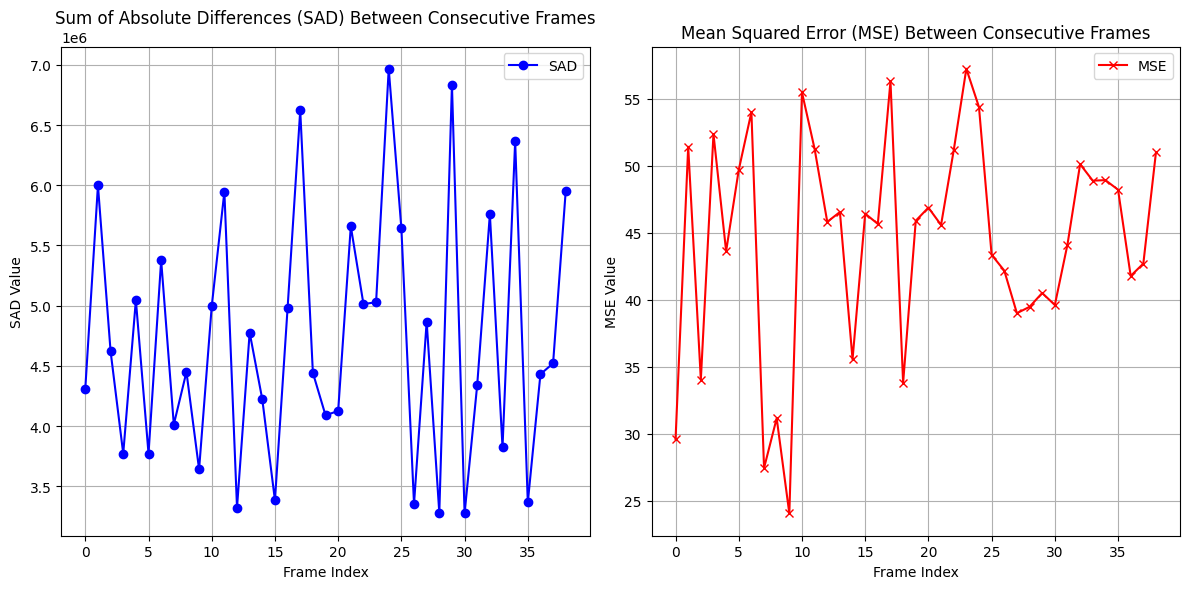

In [79]:
#jathi
avg_sad_jathi, avg_mse_jathi = pixel_wise_difference(directory_path_jathi)

Average Sum of Absolute Differences (SAD): 4027138.1694915253
Average Mean Squared Error (MSE): 20.6558635636458


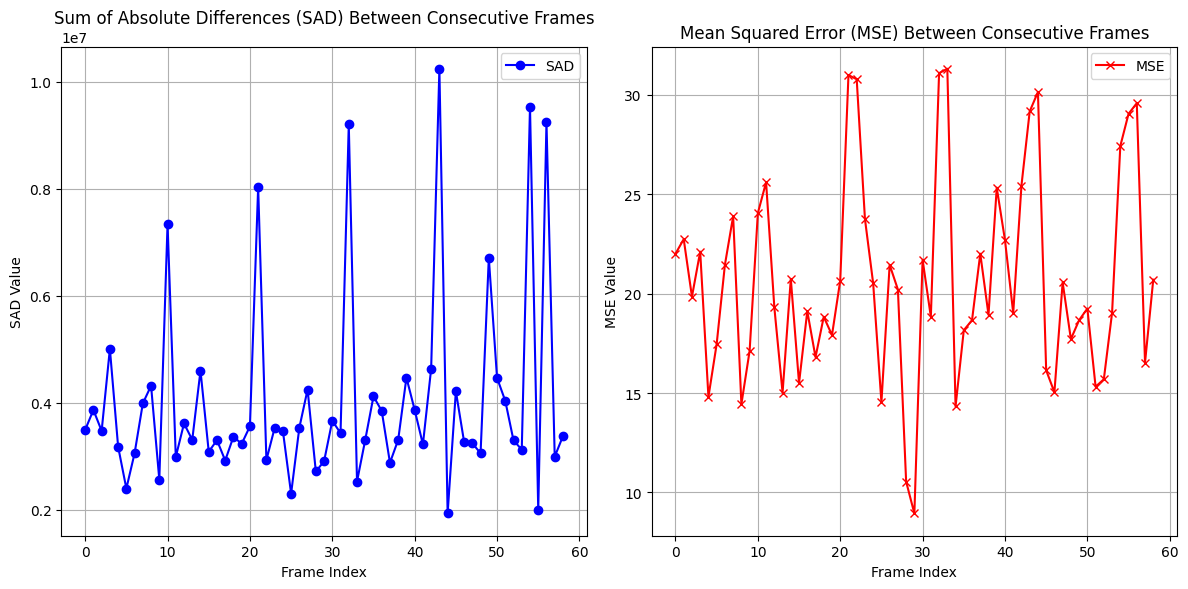

In [80]:
#padham
avg_sad_padham, avg_mse_padham = pixel_wise_difference(directory_path_padham)

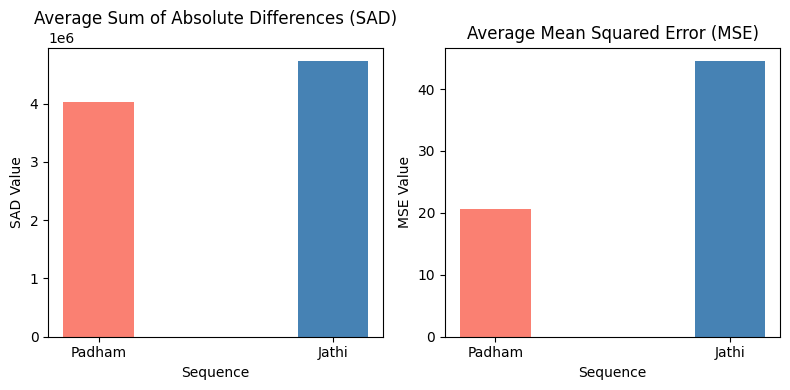

In [81]:
plt.figure(figsize=(8, 4))

labels = ['Padham', 'Jathi']

plt.subplot(1, 2, 1)
plt.bar(labels, [avg_sad_padham, avg_sad_jathi], color=['salmon', 'Steelblue'], width=0.3)
plt.title('Average Sum of Absolute Differences (SAD)')
plt.ylabel('SAD Value')
plt.xlabel('Sequence')

plt.subplot(1, 2, 2)
plt.bar(labels, [avg_mse_padham, avg_mse_jathi], color=['salmon', 'Steelblue'], width=0.3)
plt.title('Average Mean Squared Error (MSE)')
plt.ylabel('MSE Value')
plt.xlabel('Sequence')

plt.tight_layout()
plt.show()


## VGG16 - padham


In [82]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, cityblock
from fastdtw import fastdtw

# Load the pre-trained VGG16 model (exclude top classification layers)
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def preprocess_and_extract_features(img_array, model):
    # Resize the image to 224x224
    img_resized = cv2.resize(img_array, (224, 224))
    img_array = np.expand_dims(img_resized, axis=0)
    img_array = preprocess_input(img_array)

    # Extract features
    features = model.predict(img_array)
    return features.flatten()  # Flatten to 1D vector

def load_frames(directory_path, extension=".jpg"):
    frame_files = sorted([os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(extension)])
    return frame_files

def calculate_cosine_similarities(frame_files, model):
    cosine_similarities = []
    euclidean_distances = []
    manhattan_distances = []
    dtw_distances = []

    for i in range(len(frame_files) - 1):
        # Load consecutive frames
        img1 = cv2.imread(frame_files[i])
        img2 = cv2.imread(frame_files[i + 1])

        # Extract features
        features1 = preprocess_and_extract_features(img1, model)
        features2 = preprocess_and_extract_features(img2, model)

        # Compute cosine similarity
        similarity = cosine_similarity([features1], [features2])[0][0]
        cosine_similarities.append(similarity)

        # Euclidean Distance
        euclidean_dist = euclidean(features1, features2)
        euclidean_distances.append(euclidean_dist)

         # Manhattan Distance
        manhattan_dist = cityblock(features1, features2)
        manhattan_distances.append(manhattan_dist)

        # Dynamic Time Warping (DTW) using fastdtw
        distance, _ = fastdtw([features1], [features2])
        dtw_distances.append(distance)

    return cosine_similarities, euclidean_distances, manhattan_distances, dtw_distances




In [83]:
frame_files = load_frames(directory_path_padham)

cosine_similarities_padham, euclidean_distances_padham, manhattan_distances_padham, dtw_distances_padham = calculate_cosine_similarities(frame_files, model)

avg_cosine_similarity_padham = np.mean(cosine_similarities_padham)
avg_euclidean_distance_padham = np.mean(euclidean_distances_padham)
avg_manhattan_distance_padham = np.mean(manhattan_distances_padham)
avg_dtw_distance_padham = np.mean(dtw_distances_padham)

print(f"Average Cosine Similarity: {avg_cosine_similarity_padham}")
print(f"Average Euclidean Distance: {avg_euclidean_distance_padham}")
print(f"Average Manhattan Distance: {avg_manhattan_distance_padham}")
print(f"Average DTW Distance: {avg_dtw_distance_padham}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

## VGG16 - Jathi

In [84]:
frame_files = load_frames(directory_path_jathi)

cosine_similarities_jathi, euclidean_distances_jathi, manhattan_distances_jathi, dtw_distances_jathi = calculate_cosine_similarities(frame_files, model)

avg_cosine_similarity_jathi = np.mean(cosine_similarities_jathi)
avg_euclidean_distance_jathi = np.mean(euclidean_distances_jathi)
avg_manhattan_distance_jathi = np.mean(manhattan_distances_jathi)
avg_dtw_distance_jathi = np.mean(dtw_distances_jathi)

print(f"Average Cosine Similarity (Jathi): {avg_cosine_similarity_jathi}")
print(f"Average Euclidean Distance (Jathi): {avg_euclidean_distance_jathi}")
print(f"Average Manhattan Distance (Jathi): {avg_manhattan_distance_jathi}")
print(f"Average DTW Distance (Jathi): {avg_dtw_distance_jathi}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

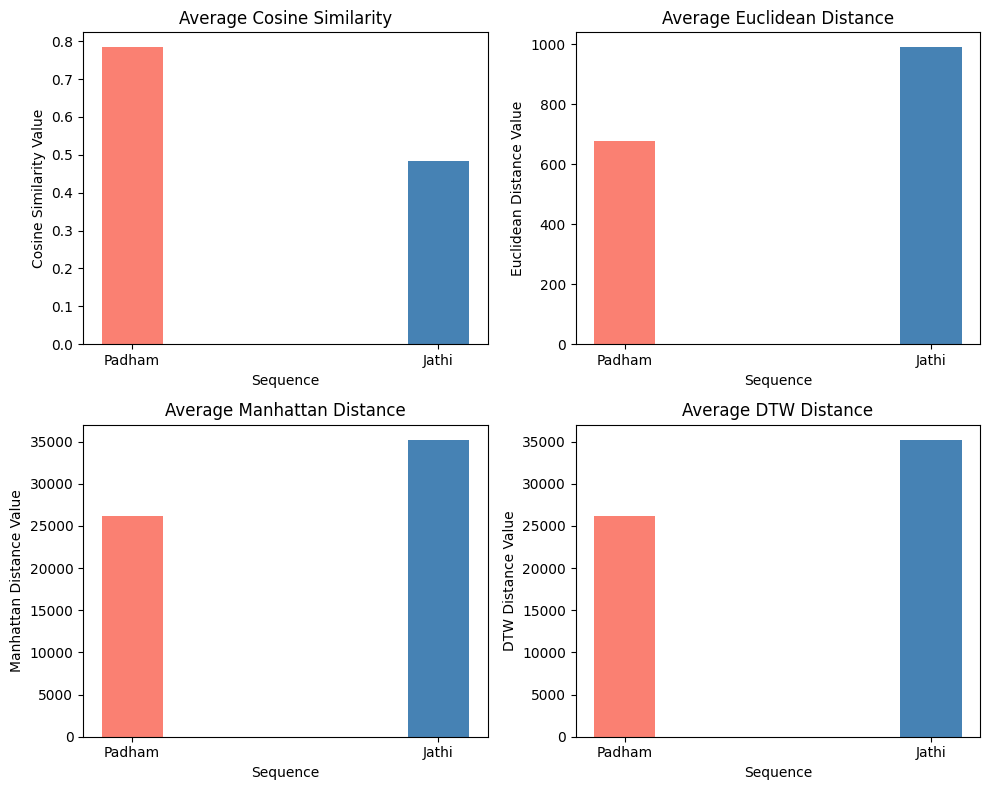

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

labels = ['Padham', 'Jathi']

# 1. Cosine Similarity Plot
axes[0, 0].bar(labels, [avg_cosine_similarity_padham, avg_cosine_similarity_jathi], color=['salmon', 'Steelblue'], width=0.2)
axes[0, 0].set_title('Average Cosine Similarity')
axes[0, 0].set_ylabel('Cosine Similarity Value')
axes[0, 0].set_xlabel('Sequence')

# 2. Euclidean Distance Plot
axes[0, 1].bar(labels, [avg_euclidean_distance_padham, avg_euclidean_distance_jathi], color=['salmon', 'Steelblue'], width=0.2)
axes[0, 1].set_title('Average Euclidean Distance')
axes[0, 1].set_ylabel('Euclidean Distance Value')
axes[0, 1].set_xlabel('Sequence')

# 3. Manhattan Distance Plot
axes[1, 0].bar(labels, [avg_manhattan_distance_padham, avg_manhattan_distance_jathi], color=['salmon', 'Steelblue'], width=0.2)
axes[1, 0].set_title('Average Manhattan Distance')
axes[1, 0].set_ylabel('Manhattan Distance Value')
axes[1, 0].set_xlabel('Sequence')

# 4. DTW Distance Plot
axes[1, 1].bar(labels, [avg_dtw_distance_padham, avg_dtw_distance_jathi], color=['salmon', 'Steelblue'], width=0.2)
axes[1, 1].set_title('Average DTW Distance')
axes[1, 1].set_ylabel('DTW Distance Value')
axes[1, 1].set_xlabel('Sequence')

plt.tight_layout()
plt.show()


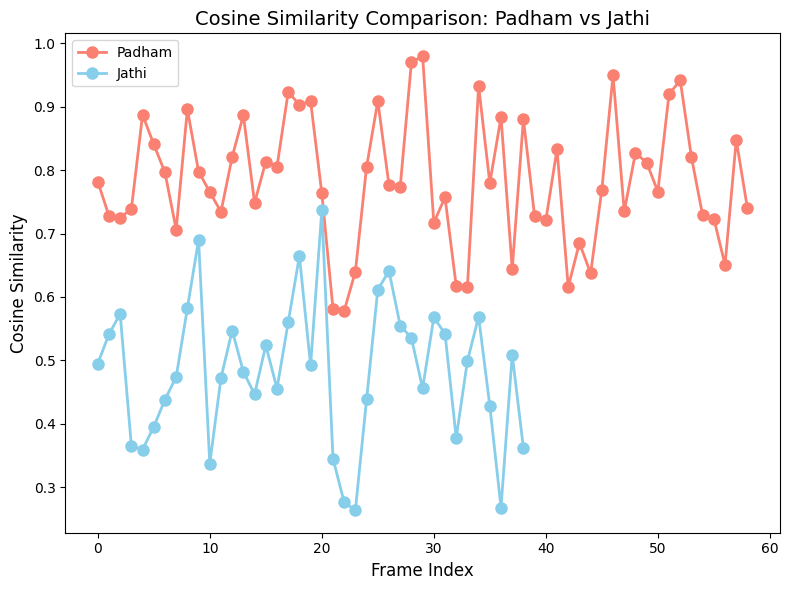

In [86]:
#line plot to compare the cosine similarities
plt.figure(figsize=(8, 6))

plt.plot(cosine_similarities_padham, label='Padham', marker='o', color='salmon', linestyle='-', linewidth=2, markersize=8)
plt.plot(cosine_similarities_jathi, label='Jathi', marker='o', color='skyblue', linestyle='-', linewidth=2, markersize=8)

plt.xlabel('Frame Index', fontsize=12)
plt.ylabel('Cosine Similarity', fontsize=12)
plt.title('Cosine Similarity Comparison: Padham vs Jathi', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()